In [196]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import json
import pickle
from networkx.generators.community import LFR_benchmark_graph
from ktools import *

importing random state


In [197]:
def save_random_state():
    random_state = np.random.get_state()
    enc = random_state[0]
    random_state_integers = random_state[1]
    random_state_params = random_state[2:]

    np.savetxt("random_state_integers.txt", random_state_integers)

    with open('random_state_params.txt', 'w') as fp:
        for item in random_state_params:
            # write each item on a new line
            fp.write("%s\n" % item)

In [198]:
save_random_state()

In [199]:
def import_random_state():
    random_state_integers = np.loadtxt("random_state_integers.txt")
    enc="MT19937"
    params = []
    with open(r'random_state_params.txt', 'r') as fp:
        for line in fp:
            # remove linebreak from a current name
            # linebreak is the last character of each line
            x = line[:-1]

            # add current item to the list
            params.append(x)

    params[0] = int(params[0])
    params[1] = int(params[1])
    params[2] = float(params[2])

    params.insert(0,enc)
    params.insert(1, random_state_integers)
    
    return tuple(params)

In [200]:
np.random.set_state(import_random_state())

## Generating Synthetic Networks

### Small50

In [201]:

n = 50
tau1 = 2.5
tau2 = 1.5
mu = 0.225
G = LFR_benchmark_graph(
    n, tau1, tau2, mu,min_degree=2, min_community=5,max_iters=10000
)


In [202]:
a = [G.nodes[v]["community"] for v in G]
I = flow_id_from_graph(G)
G = nx.from_numpy_array(I)
nx.set_node_attributes(G, dict(enumerate(a)), "community")


100%|██████████| 50/50 [00:00<00:00, 61.03it/s]


In [203]:
pickle.dump(G, open('small50.pickle', 'wb'))
G = pickle.load(open('small50.pickle', 'rb'))

In [204]:
def net_comm_stats(G: nx.Graph, title:str, node_size=300, show_graph=False)->dict:
    """Creates a dictionary of summary statistics for a list of communties

    Args:
        G nx.Graph: Graph that originated the communities
        title str: Title of the graph
    Returns:
        dict: summary statistics
    """    
    comms = {frozenset(G.nodes[v]["community"]) for v in G}
    comms = [list(x) for x in comms]

    # ------------------------- create summary statistics ------------------------ #
    stats = {}
    stats["n_of_nodes"] = len(G.nodes)
    stats["n_edges"] = len(G.edges)

    stats["a_comm_size"] = np.mean([len(c) for c in comms])
    stats["var_comm_size"] = np.var([len(c) for c in comms])

    stats["a_deg"] = np.mean([x for x in dict(nx.degree(G)).values()])
    stats["min_deg"] = np.min([x for x in dict(nx.degree(G)).values()])
    stats["max_deg"] = np.max([x for x in dict(nx.degree(G)).values()])
    
    stats["a_btw_centrality"] = np.mean([x for x in nx.betweenness_centrality(G).values()])

    if show_graph:
        color_dict = {}

        a = [frozenset(G.nodes[v]['community']) for v in G]    

        for node in a:
            if node not in color_dict:
                color_dict[node] = 0

        for i,key in enumerate(color_dict.keys()):
            color_dict[key] = plt.colormaps["tab20"](i)

        pos = nx.kamada_kawai_layout(G)
        node_colors = [color_dict[frozenset(G.nodes[node]['community'])] for node in G.nodes]
        nx.draw(G, node_color=node_colors, node_size=node_size, font_size=16,  arrows=True, pos=pos, with_labels=True)
        plt.title(f"Graph of the {title} network, with underlying communities", fontsize=16)

    return stats


{'n_of_nodes': 50,
 'n_edges': 87,
 'a_comm_size': 5.0,
 'var_comm_size': 0.0,
 'a_deg': 3.48,
 'min_deg': 0,
 'max_deg': 8,
 'a_btw_centrality': 0.09994897959183673}

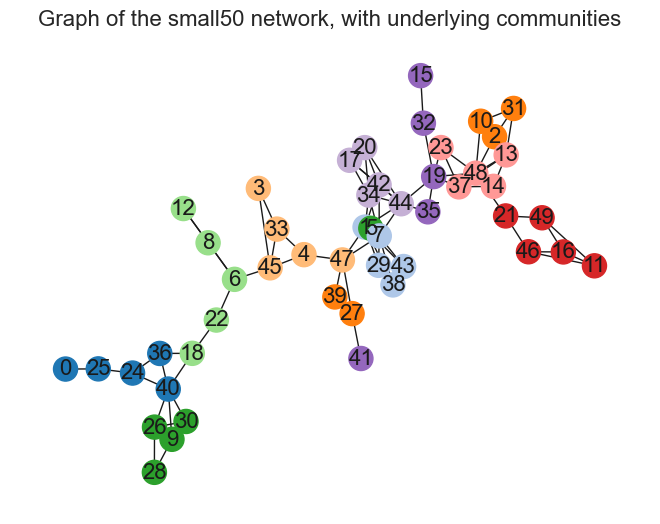

In [205]:
net_comm_stats(G, "small50", show_graph=True)

## Medium 250

In [206]:
n = 250
tau1 = 2.5
tau2 = 1.5
mu = 0.225
G = LFR_benchmark_graph(
    n, tau1, tau2, mu,average_degree=6, min_community=20,max_iters=1000, 
)


In [207]:
a = [G.nodes[v]["community"] for v in G]
I = flow_id_from_graph(G)
G = nx.from_numpy_array(I)
nx.set_node_attributes(G, dict(enumerate(a)), "community")


 35%|███▌      | 88/250 [01:30<02:16,  1.19it/s]

In [ ]:
pickle.dump(G, open('medium250.pickle', 'wb'))
G = pickle.load(open('medium250.pickle', 'rb'))

In [ ]:
net_comm_stats(G, "medium250", 50)

{'n_of_nodes': 250,
 'n_edges': 613,
 'a_comm_size': 25.0,
 'var_comm_size': 5.2,
 'a_deg': 4.904,
 'min_deg': 2,
 'max_deg': 29,
 'a_btw_centrality': 0.01111789091851276}

In [ ]:
n = 2500
tau1 = 2.5
tau2 = 1.5
mu = 0.225
G = LFR_benchmark_graph(
    n, tau1, tau2, mu,average_degree=6, min_community=50, max_iters=1000)


In [ ]:
a = [G.nodes[v]["community"] for v in G]
I = flow_id_from_graph(G)
G = nx.from_numpy_array(I)
nx.set_node_attributes(G, dict(enumerate(a)), "community")

In [ ]:
pickle.dump(G, open('large250.pickle', 'wb'))
G = pickle.load(open('large250.pickle', 'rb'))

In [ ]:
net_comm_stats(G, "large250", 50)

{'n_of_nodes': 2500,
 'n_edges': 8141,
 'a_comm_size': 147.05882352941177,
 'var_comm_size': 5245.467128027682,
 'a_deg': 6.5128,
 'min_deg': 2,
 'max_deg': 353,
 'a_btw_centrality': 0.001158713349230805}

## Generating Training Sets

100%|██████████| 250/250 [03:17<00:00,  1.27it/s]


{'weight': 1.0}